# 1. Split des données (train / valid / test)
---

On commence le Split des données (train / valid / test), une étape clé avant tout entraînement.

### Objectif

Diviser le dataset en trois sous-ensembles :

- train (≈70%) : pour entraîner le modèle,

- validation (≈15%) : pour ajuster les hyperparamètres,

- test (≈15%) : pour évaluer les performances finales (jamais vu pendant le training).

Ce découpage doit être stratifié afin de conserver la même proportion de fraudes (≈0,17 %) dans chaque sous-ensemble.

### Pourquoi cette étape est essentielle ?

- Évite les fuites de données entre apprentissage et test.

- Garantit une évaluation juste et reproductible.

- Le stratified split empêche que le jeu de test ne contienne par hasard aucune fraude, ce qui serait catastrophique pour l’évaluation du rappel (recall).

## 1.1 Imports et configuration

In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split

# Charger le dataset complet (issu de l’EDA)
df = pd.read_csv("../data/raw/creditcard.csv")

# Vérification
print("Dimensions initiales :", df.shape)
print("Taux de fraudes :", df['Class'].mean() * 100, "%")


import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

from visualizations_models import (
    plot_model_evaluation_complete,
    compare_models_roc,
    print_classification_report_styled
)

%matplotlib inline
plt.rcParams['figure.dpi'] = 100
plt.rcParams['savefig.dpi'] = 300

print("✅ Imports des visualisations chargés !")


Dimensions initiales : (284807, 31)
Taux de fraudes : 0.1727485630620034 %
✅ Imports des visualisations chargés !


## 1.2 Séparation features / target

In [2]:
# Variables explicatives (toutes sauf 'Class')
X = df.drop(columns=['Class'])
y = df['Class']

print("X shape:", X.shape)
print("y shape:", y.shape)


X shape: (284807, 30)
y shape: (284807,)


## 1.3 Split train / temp (85% / 15%)
On crée d’abord un grand ensemble d’apprentissage + un ensemble “temporaire” pour validation/test.

In [3]:
X_train, X_temp, y_train, y_temp = train_test_split(
    X, y, 
    test_size=0.30,       # 70% / 30%
    stratify=y, 
    random_state=42
)
print("Train set shape:", X_train.shape, y_train.shape)

Train set shape: (199364, 30) (199364,)


## 1.4 Split du temp en validation / test

In [4]:
X_valid, X_test, y_valid, y_test = train_test_split(
    X_temp, y_temp,
    test_size=0.5,        # 15% validation, 15% test
    stratify=y_temp,
    random_state=42
)
print("Validation set shape:", X_valid.shape, y_valid.shape)

Validation set shape: (42721, 30) (42721,)


## 1.5 Vérification du taux de fraudes dans chaque split

In [5]:
def fraud_ratio(y):
    return round(y.mean() * 100, 4)

print(f"Taille Train : {len(X_train)} | Fraudes : {fraud_ratio(y_train)} %")
print(f"Taille Valid : {len(X_valid)} | Fraudes : {fraud_ratio(y_valid)} %")
print(f"Taille Test  : {len(X_test)} | Fraudes : {fraud_ratio(y_test)} %")


Taille Train : 199364 | Fraudes : 0.1725 %
Taille Valid : 42721 | Fraudes : 0.1732 %
Taille Test  : 42722 | Fraudes : 0.1732 %


## 1.6 Sauvegarde les sous-ensembles préparés

In [6]:
X_train.to_csv("../data/processed/X_train.csv", index=False)
X_valid.to_csv("../data/processed/X_valid.csv", index=False)
X_test.to_csv("../data/processed/X_test.csv", index=False)

y_train.to_csv("../data/processed/y_train.csv", index=False)
y_valid.to_csv("../data/processed/y_valid.csv", index=False)
y_test.to_csv("../data/processed/y_test.csv", index=False)


# 2. Normalisation & sélection de features
---

### Objectif

Préparer les variables pour les modèles :

- normaliser les colonnes qui ne sont pas déjà standardisées,

- sélectionner les features pertinentes (on garde tout pour l’instant, sauf si une variable est inutile).

### Pourquoi normaliser ?

Les colonnes V1 à V28 proviennent d’une PCA : elles sont déjà centrées et réduites (moyenne ≈ 0, écart-type ≈ 1).
Mais les deux colonnes non PCA :

- Amount → très asymétrique (de 0 à 25 000 €)

- Time → non normalisée (0 à 172 792 secondes)
sont à normaliser ou transformer pour éviter de dominer les autres variables dans les modèles sensibles à l’échelle (LogReg, SVM, etc.)

## 2.1 Normalisation des variables Amount et Time

In [7]:
from sklearn.preprocessing import StandardScaler

# Rechargement rapide (si nécessaire)
import pandas as pd
X_train = pd.read_csv("../data/processed/X_train.csv")
X_valid = pd.read_csv("../data/processed/X_valid.csv")
X_test = pd.read_csv("../data/processed/X_test.csv")

# Sélection des colonnes à normaliser
cols_to_scale = ['Amount', 'Time']

# Initialisation du scaler
scaler = StandardScaler()

# Ajustement sur l'ensemble d'entraînement uniquement
X_train[cols_to_scale] = scaler.fit_transform(X_train[cols_to_scale])

# Transformation des ensembles de validation et test
X_valid[cols_to_scale] = scaler.transform(X_valid[cols_to_scale])
X_test[cols_to_scale] = scaler.transform(X_test[cols_to_scale])

print("Normalisation terminée ✅")
print(X_train[cols_to_scale].describe().T)


Normalisation terminée ✅
           count          mean       std       min       25%       50%  \
Amount  199364.0  1.094163e-17  1.000003 -0.349257 -0.326851 -0.262323   
Time    199364.0 -1.055671e-16  1.000003 -1.998286 -0.855856 -0.211681   

             75%         max  
Amount -0.043012  101.170569  
Time    0.936344    1.640221  


## 2.2 Vérification graphique

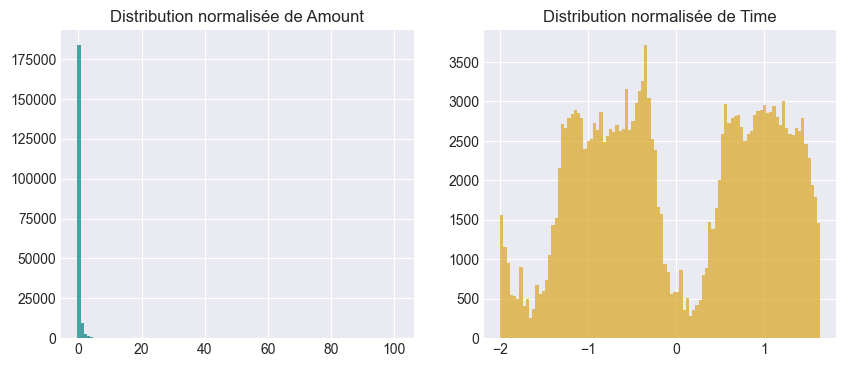

In [8]:
import matplotlib.pyplot as plt

fig, axes = plt.subplots(1, 2, figsize=(10,4))
axes[0].hist(X_train['Amount'], bins=100, color='teal', alpha=0.7)
axes[0].set_title("Distribution normalisée de Amount")
axes[1].hist(X_train['Time'], bins=100, color='goldenrod', alpha=0.7)
axes[1].set_title("Distribution normalisée de Time")
plt.show()


- **À gauche (Amount)** :
Après normalisation, la distribution reste fortement asymétrique : la majorité des valeurs sont concentrées autour de 0, avec une longue traîne vers la droite. Cela reflète le fait que la plupart des transactions portent sur de faibles montants, tandis que quelques opérations isolées atteignent des valeurs plus élevées.

- **À droite (Time)** :
La distribution normalisée conserve la double structure cyclique observée précédemment, correspondant à deux journées consécutives d’activité. La normalisation n’a pas modifié la forme, mais a ramené les valeurs sur une échelle centrée autour de 0, facilitant ainsi leur utilisation dans les modèles d’apprentissage.

Après normalisation, Amount reste asymétrique (petits montants majoritaires) tandis que Time conserve son cycle sur deux jours.
Ces deux variables sont désormais prêtes à être intégrées au modèle, avec des échelles comparables aux autres variables PCA.

## 2.3 Sauvegarde des données normalisées

In [9]:
X_train.to_csv("../data/processed/X_train_scaled.csv", index=False)
X_valid.to_csv("../data/processed/X_valid_scaled.csv", index=False)
X_test.to_csv("../data/processed/X_test_scaled.csv", index=False)


# 3. Gestion du déséquilibre des classes
---

### Objectif

Le dataset contient 0.17 % de fraudes, donc une classe extrêmement minoritaire.  
Sans correction, un modèle pourrait prédire “0” partout et obtenir 99,8 % de précision, mais **0 en rappel** sur les fraudes — ce qui est inacceptable dans un contexte de sécurité bancaire.

On va donc comparer deux stratégies de gestion du déséquilibre :

- **Undersampling** → réduire la classe majoritaire.  
- **SMOTE (Oversampling)** → créer artificiellement des fraudes synthétiques pour renforcer la classe minoritaire.

Ces deux approches seront évaluées afin d’observer leur effet sur la distribution des classes et leur pertinence pour la phase de modélisation.

## 3.1 Imports

In [10]:
from collections import Counter
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
import pandas as pd
import matplotlib.pyplot as plt



## 3.2 Vérification du déséquilibre avant rééchantillonnage

In [11]:
y_train = pd.read_csv("../data/processed/y_train.csv").squeeze()

print("Distribution initiale de y_train :", Counter(y_train))

Distribution initiale de y_train : Counter({0: 199020, 1: 344})


## 3.3 Exemple 1 : Undersampling
Cela crée un dataset équilibré à 2 pour 1 environ (plus petit, mais rapide à entraîner).

In [12]:
X_train = pd.read_csv("../data/processed/X_train_scaled.csv")

rus = RandomUnderSampler(sampling_strategy=0.5, random_state=42)
X_res, y_res = rus.fit_resample(X_train, y_train)

print("Nouvelle distribution après undersampling :", Counter(y_res))



Nouvelle distribution après undersampling : Counter({0: 688, 1: 344})


## 3.4 Exemple 2 : SMOTE (Oversampling)
Cela crée artificiellement plus d’exemples de fraude jusqu’à un ratio de 20 % de la classe majoritaire.

In [13]:
smote = SMOTE(sampling_strategy=0.2, random_state=42, k_neighbors=5)
X_smote, y_smote = smote.fit_resample(X_train, y_train)

print("Nouvelle distribution après SMOTE :", Counter(y_smote))


Nouvelle distribution après SMOTE : Counter({0: 199020, 1: 39804})


## 3.5 Visualisation rapide

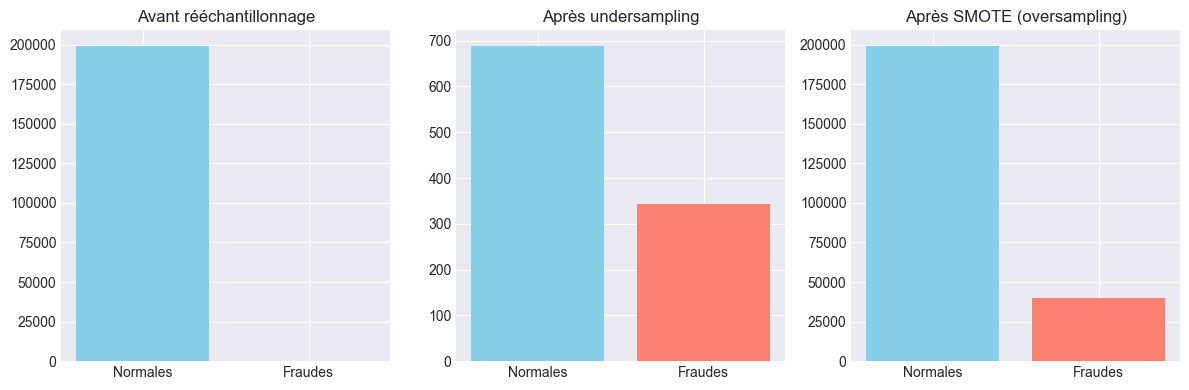

In [14]:
labels = ['Normales', 'Fraudes']
before = [Counter(y_train)[0], Counter(y_train)[1]]
after_smote = [Counter(y_smote)[0], Counter(y_smote)[1]]
after_rus = [Counter(y_res)[0], Counter(y_res)[1]]

fig, ax = plt.subplots(1, 3, figsize=(12,4))
ax[0].bar(labels, before, color=['skyblue', 'salmon'])
ax[0].set_title("Avant rééchantillonnage")
ax[1].bar(labels, after_rus, color=['skyblue', 'salmon'])
ax[1].set_title("Après undersampling")
ax[2].bar(labels, after_smote, color=['skyblue', 'salmon'])
ax[2].set_title("Après SMOTE (oversampling)")
plt.tight_layout()
plt.show()


### 🔍 Choix de la stratégie de gestion du déséquilibre

Dans cette étape, deux approches principales ont été envisagées pour gérer le fort déséquilibre entre les classes :

- **Undersampling** : réduction du nombre d’exemples de la classe majoritaire (transactions normales),
- **SMOTE (Synthetic Minority Over-sampling Technique)** : création artificielle d’exemples de la classe minoritaire (fraudes).

Les résultats obtenus montrent que **SMOTE** permet d’obtenir un jeu de données plus équilibré tout en conservant la diversité des transactions normales.  
Cette approche sera **retenue comme stratégie principale de rééquilibrage** pour la suite du projet.

➡️ Ce choix est motivé par :
- le **déséquilibre extrême** du dataset (~0,17 % de fraudes),
- la **taille suffisante** de la classe majoritaire pour créer des exemples synthétiques fiables,
- et la compatibilité avec les modèles envisagés (RandomForest, XGBoost).

SMOTE sera intégré **dans le pipeline scikit-learn** lors de la phase de modélisation,  
afin de garantir qu’il ne soit appliqué **qu’aux données d’entraînement**, évitant ainsi toute fuite de données.


---

- Les données ont été divisées en trois ensembles **stratifiés** : train (70 %), validation (15 %), test (15 %).  
- Les variables `Amount` et `Time` ont été **normalisées** via `StandardScaler`.  
- Le déséquilibre extrême des classes (0.17 % de fraudes) a été traité par **SMOTE**, qui sera intégré dans le pipeline de modélisation.  

✅ Le dataset est désormais propre, standardisé et prêt pour la **phase 3 — Modélisation**.


📁 Les sous-ensembles `train`, `valid` et `test` ont été enregistrés dans le dossier `data/processed/`
afin d’être directement réutilisés dans la phase de modélisation.


# 4. Construction d’un pipeline scikit-learn
---

### 🎯 Objectif

Mettre en place un **pipeline complet** de prétraitement et d’entraînement qui regroupe toutes les étapes clés :
- **Normalisation** des variables `Amount` et `Time` (via `StandardScaler`),
- **Rééchantillonnage** avec **SMOTE** pour corriger le déséquilibre de classes,
- **Entraînement du modèle** (Logistic Regression, Random Forest, XGBoost).

Ce pipeline sera utilisé pour :
- **éviter les fuites de données** (toutes les étapes sont encapsulées et rejouées uniquement sur l’ensemble d’entraînement),
- **simplifier la cross-validation** (scikit-learn refait le pipeline à chaque fold),
- **garantir la reproductibilité** du prétraitement à la phase de déploiement (Streamlit).

Nous allons construire une fonction générique `make_pipeline_with_smote(model)`  
qui permettra d’instancier facilement un pipeline complet avec le modèle souhaité.


## 4.1 Import + Colonnes

In [15]:
import pandas as pd
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler
from imblearn.pipeline import Pipeline as ImbPipeline
from imblearn.over_sampling import SMOTE

# On repart des splits NON scalés (on scale DANS le pipeline)
X_train = pd.read_csv("../data/processed/X_train.csv")
y_train = pd.read_csv("../data/processed/y_train.csv").squeeze()

scale_cols = ["Amount", "Time"]
all_cols = X_train.columns.tolist()
pass_through_cols = [c for c in all_cols if c not in scale_cols]

scale_cols, pass_through_cols[:5]


(['Amount', 'Time'], ['V1', 'V2', 'V3', 'V4', 'V5'])

## 4.2 Préprocessing

In [16]:
# Scaler pour Amount/Time, le reste (V1..V28) passe tel quel
preprocess = ColumnTransformer(
    transformers=[("scale_amt_time", StandardScaler(), scale_cols)],
    remainder="passthrough"
)


## 4.3 Fabrique de pipeline (prep → SMOTE → model)

In [17]:
def make_pipeline_with_smote(model, smote_ratio=0.20, random_state=42):
    """
    Pipeline: preprocess -> SMOTE -> model
    SMOTE est appliqué dans le pipeline (anti-fuite en CV).
    """
    return ImbPipeline(steps=[
        ("prep", preprocess),
        ("smote", SMOTE(sampling_strategy=smote_ratio, random_state=random_state, k_neighbors=5)),
        ("model", model),
    ])


## 4.4 Instanciation de la baseline (LogReg)

In [18]:
from sklearn.linear_model import LogisticRegression

logreg = LogisticRegression(max_iter=1000, solver="lbfgs")
pipe_logreg = make_pipeline_with_smote(logreg, smote_ratio=0.20, random_state=42)
pipe_logreg


,steps,"[('prep', ...), ('smote', ...), ...]"
,transform_input,None
,memory,None
,verbose,False
,transformers,"[('scale_amt_time', ...)]"
,remainder,'passthrough'
,sparse_threshold,0.3
,n_jobs,None
,transformer_weights,None
,verbose,False
,verbose_feature_names_out,True


## 4.5 Préparer RF et XGB (sans fit)

In [19]:
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier

rf = RandomForestClassifier(
    n_estimators=300, n_jobs=-1, random_state=42
)

xgb = XGBClassifier(
    n_estimators=400, learning_rate=0.08, max_depth=5,
    subsample=0.9, colsample_bytree=0.9,
    tree_method="hist", eval_metric="logloss",
    random_state=42
)

pipe_rf  = make_pipeline_with_smote(rf,  smote_ratio=0.20, random_state=42)
pipe_xgb = make_pipeline_with_smote(xgb, smote_ratio=0.20, random_state=42)

pipe_rf, pipe_xgb


(Pipeline(steps=[('prep',
                  ColumnTransformer(remainder='passthrough',
                                    transformers=[('scale_amt_time',
                                                   StandardScaler(),
                                                   ['Amount', 'Time'])])),
                 ('smote', SMOTE(random_state=42, sampling_strategy=0.2)),
                 ('model',
                  RandomForestClassifier(n_estimators=300, n_jobs=-1,
                                         random_state=42))]),
 Pipeline(steps=[('prep',
                  ColumnTransformer(remainder='passthrough',
                                    transformers=[('scale_amt_time',
                                                   StandardScaler(),
                                                   ['Amount', 'Time'])])),
                 ('smote', SMOTE(random_state=42, sampling_strategy=0.2)),
                 ('model',
                  XGBClassifier(base_score=None, booster=None, c

**Notes méthodologiques**
- Le scaling d’`Amount` et `Time` est fait **dans** le `ColumnTransformer`.
- **SMOTE** est **dans** le pipeline, entre prétraitement et modèle.
- En cross-validation, le pipeline est re-fit à chaque fold → **pas de fuite** (SMOTE ne voit pas la validation).
- Nous n’utilisons pas `class_weight` ici car la stratégie principale retenue est **SMOTE** (comparaisons ultérieures possibles).


# 5.Validation & sauvegarde
---

## 5.1 Imports + chargement des jeux (non scalés)

In [20]:
import os, json, joblib
import numpy as np
import pandas as pd

from sklearn.metrics import (
    precision_recall_curve, roc_auc_score, average_precision_score,
    precision_score, recall_score, f1_score, confusion_matrix
)

# Recharger les splits NON scalés (car le scaling est DANS le pipeline)
X_train = pd.read_csv("../data/processed/X_train.csv")
y_train = pd.read_csv("../data/processed/y_train.csv").squeeze()

X_valid = pd.read_csv("../data/processed/X_valid.csv")
y_valid = pd.read_csv("../data/processed/y_valid.csv").squeeze()

print(X_train.shape, X_valid.shape, y_train.shape, y_valid.shape)


(199364, 30) (42721, 30) (199364,) (42721,)


## 5.2 Choix du modèle à valider (baseline)

In [21]:
# Reprise du pipeline déjà construit en 4
pipe = pipe_logreg  # <- baseline à valider
pipe


,steps,"[('prep', ...), ('smote', ...), ...]"
,transform_input,None
,memory,None
,verbose,False
,transformers,"[('scale_amt_time', ...)]"
,remainder,'passthrough'
,sparse_threshold,0.3
,n_jobs,None
,transformer_weights,None
,verbose,False
,verbose_feature_names_out,True


## 5.3 Fit du pipeline + premières métriques (AUC)

In [22]:
# Entraîner la baseline sur TRAIN et obtenir les proba sur VALID
pipe.fit(X_train, y_train)

valid_proba = pipe.predict_proba(X_valid)[:, 1]

from sklearn.metrics import roc_auc_score, average_precision_score
print("AUC ROC (valid) :", roc_auc_score(y_valid, valid_proba))
print("PR-AUC (valid)  :", average_precision_score(y_valid, valid_proba))


AUC ROC (valid) : 0.9683119879792565
PR-AUC (valid)  : 0.6561395837905155


## 5.4 Choisir un seuil (Recall prioritaire, Precision ≥ 0.20)

In [23]:
import numpy as np
from sklearn.metrics import precision_recall_curve

def choose_threshold_by_precision_recall(y_true, y_proba, precision_min=0.20):
    precisions, recalls, thresholds = precision_recall_curve(y_true, y_proba)
    thresholds = np.append(thresholds, 1.0)  # aligner tailles avec precisions/recalls
    mask = precisions >= precision_min

    if not np.any(mask):
        # fallback: meilleur F1 si aucune config n'atteint la précision cible
        f1s = 2 * (precisions * recalls) / (precisions + recalls + 1e-12)
        idx = np.nanargmax(f1s)
        return float(thresholds[idx]), {
            "precision": float(precisions[idx]),
            "recall": float(recalls[idx]),
            "strategy": "best_f1_fallback"
        }

    recalls_masked = recalls.copy()
    recalls_masked[~mask] = -1
    idx = np.argmax(recalls_masked)
    return float(thresholds[idx]), {
        "precision": float(precisions[idx]),
        "recall": float(recalls[idx]),
        "strategy": "max_recall_at_precision>=0.20"
    }

best_thr, thr_info = choose_threshold_by_precision_recall(y_valid, valid_proba, precision_min=0.20)
best_thr, thr_info


(0.48308179776844534,
 {'precision': 0.2,
  'recall': 0.8378378378378378,
  'strategy': 'max_recall_at_precision>=0.20'})

## 5.5 Métriques finales sur validation

In [24]:
from sklearn.metrics import precision_score, recall_score, f1_score, confusion_matrix, roc_auc_score, average_precision_score

valid_pred = (valid_proba >= best_thr).astype(int)

cm = confusion_matrix(y_valid, valid_pred)
tn, fp, fn, tp = cm.ravel()

metrics = {
    "threshold": float(best_thr),
    "threshold_selection": thr_info,
    "precision": float(precision_score(y_valid, valid_pred, zero_division=0)),
    "recall": float(recall_score(y_valid, valid_pred, zero_division=0)),
    "f1": float(f1_score(y_valid, valid_pred, zero_division=0)),
    "roc_auc": float(roc_auc_score(y_valid, valid_proba)),
    "pr_auc": float(average_precision_score(y_valid, valid_proba)),
    "support_fraud": int(y_valid.sum()),
    "support_normal": int((1 - y_valid).sum()),
    "confusion_matrix": {"tn": int(tn), "fp": int(fp), "fn": int(fn), "tp": int(tp)},
}
metrics


{'threshold': 0.48308179776844534,
 'threshold_selection': {'precision': 0.2,
  'recall': 0.8378378378378378,
  'strategy': 'max_recall_at_precision>=0.20'},
 'precision': 0.2,
 'recall': 0.8378378378378378,
 'f1': 0.3229166666666667,
 'roc_auc': 0.9683119879792565,
 'pr_auc': 0.6561395837905155,
 'support_fraud': 74,
 'support_normal': 42647,
 'confusion_matrix': {'tn': 42399, 'fp': 248, 'fn': 12, 'tp': 62}}

### Synthèse - Baseline Logistic Regression

Le pipeline **prep → SMOTE → Logistic Regression** atteint un excellent compromis :
- **Recall élevé** : ≈ 84% des fraudes détectées
- **ROC-AUC** : 0.97 (excellente discrimination)
- **Precision** : 20% (1 vraie fraude pour 4 fausses alertes)

Cette baseline confirme que :
✅ Le pipeline fonctionne correctement
✅ SMOTE améliore significativement la détection
✅ Le seuil choisi privilégie le Recall (stratégie bancaire)

**→ Nous pouvons maintenant comparer rigoureusement ce modèle avec des 
approches plus complexes (Random Forest, XGBoost) en Section 6.**

## 5.6 Sauvegarde du pipeline entraîné

In [26]:
import os, json, joblib
from datetime import datetime

tag = "logreg_smote_v1"
run_dir = f"../models/{tag}"
os.makedirs(run_dir, exist_ok=True)

# 1) Sauvegarder le pipeline entraîné
joblib.dump(pipe, os.path.join(run_dir, "pipeline.joblib"))

# 2) Sauvegarder les métriques + seuil
with open(os.path.join(run_dir, "metrics_valid.json"), "w", encoding="utf-8") as f:
    json.dump(metrics, f, indent=2, ensure_ascii=False)

# 3) Info colonnes (utile au déploiement)
cols_info = {
    "scale_cols": ["Amount", "Time"],
    "all_cols": X_train.columns.tolist(),
    "generated_at": datetime.now().isoformat(timespec="seconds"),
}
with open(os.path.join(run_dir, "columns.json"), "w", encoding="utf-8") as f:
    json.dump(cols_info, f, indent=2, ensure_ascii=False)

print("✅ Pipeline et artefacts sauvegardés dans :", run_dir)


✅ Pipeline et artefacts sauvegardés dans : ../models/logreg_smote_v1


## 5.6 Lister le contenu du dossier modèle

In [27]:
import os, json

run_dir = "../models/logreg_smote_v1"
print("Contenu de", run_dir, ":\n", os.listdir(run_dir))

# Afficher un extrait des métriques enregistrées
with open(os.path.join(run_dir, "metrics_valid.json"), "r", encoding="utf-8") as f:
    m = json.load(f)
print("\nExtrait metrics_valid.json:\n", {k: m[k] for k in ["threshold","precision","recall","pr_auc","roc_auc"]})


Contenu de ../models/logreg_smote_v1 :
 ['columns.json', 'metrics_valid.json', 'pipeline.joblib']

Extrait metrics_valid.json:
 {'threshold': 0.48308179776844534, 'precision': 0.2, 'recall': 0.8378378378378378, 'pr_auc': 0.6561395837905155, 'roc_auc': 0.9683119879792565}


## 5.7 Test pour valider la cohérence du pipeline sauvegardé

In [28]:
import joblib
import numpy as np
from sklearn.metrics import precision_score, recall_score

# Rechargement
pipe_reloaded = joblib.load(os.path.join(run_dir, "pipeline.joblib"))

# Probabilités & prédictions avec le seuil sauvegardé
thr = m["threshold"]
valid_proba_reload = pipe_reloaded.predict_proba(X_valid)[:, 1]
valid_pred_reload = (valid_proba_reload >= thr).astype(int)

print("Precision (reload):", precision_score(y_valid, valid_pred_reload, zero_division=0))
print("Recall    (reload):", recall_score(y_valid, valid_pred_reload, zero_division=0))


Precision (reload): 0.2
Recall    (reload): 0.8378378378378378


**Les données sont désormais prêtes pour la modélisation.**
**Le pipeline complet a été testé, validé et enregistré avec ses métriques et paramètres.**

# 6. Modélisation supervisée
---

## Objectif général

Comparer plusieurs modèles de Machine Learning afin de déterminer celui qui détecte le mieux les fraudes :

1. **Logistic Regression** (modèle linéaire de base)
2. **Random Forest** (modèle d'ensemble interprétable)
3. **XGBoost** (boosting performant)

Chaque modèle sera évalué avec les mêmes conditions :

- pipeline complet (scaler + SMOTE + modèle),
- validation croisée stratifiée (5 folds),
- métriques : Recall, Precision, F1-score, PR-AUC, ROC-AUC.

**Plan de la Modélisation**
| Étape   | Description                                      |
| ------- | ------------------------------------------------ |
| **1** | Mise en place de la cross-validation stratifiée  |
| **2** | Validation croisée du modèle Logistic Regression |
| **3** | Validation croisée du modèle Random Forest       |
| **4** | Validation croisée du modèle XGBoost             |
| **5** | Comparaison finale des performances              |
| **6** | Sélection et sauvegarde du meilleur modèle       |


## 6.1 Setup CV & métriques

In [29]:
from sklearn.model_selection import StratifiedKFold

scoring = {
    "roc_auc": "roc_auc",
    "pr_auc": "average_precision",
    "recall": "recall",
    "precision": "precision",
    "f1": "f1"
}
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
print("✅ Scoring et CV (5 folds) prêts.")


✅ Scoring et CV (5 folds) prêts.


## 6.2 Cross-validation Logistic Regression (baseline)

In [30]:
from sklearn.model_selection import cross_validate
import numpy as np

print("🔄 CV Logistic Regression (5 folds)...")
cv_results_logreg = cross_validate(
    pipe_logreg,      
    X_train, y_train, 
    cv=cv,
    scoring=scoring,
    n_jobs=-1,
    return_train_score=False
)

# Résumé propre
for metric, values in cv_results_logreg.items():
    if metric.startswith("test_"):
        name = metric.replace("test_", "")
        print(f"{name:>10s} : {np.mean(values):.4f} ± {np.std(values):.4f}")


🔄 CV Logistic Regression (5 folds)...
   roc_auc : 0.9817 ± 0.0082
    pr_auc : 0.7825 ± 0.0385
    recall : 0.8866 ± 0.0252
 precision : 0.2274 ± 0.0155
        f1 : 0.3615 ± 0.0179


**Interprétation des résultats – Logistic Regression (5-fold CV)**

| Métrique      | Moyenne ± Écart-type | Interprétation                                                                                          |
| ------------- | -------------------- | ------------------------------------------------------------------------------------------------------- |
| **ROC-AUC**   | 0.9817 ± 0.0082      | Excellente capacité globale de séparation entre fraudes et normales.                                    |
| **PR-AUC**    | 0.7825 ± 0.0385      | Très bon pour un dataset aussi déséquilibré ; la courbe Precision-Recall montre un modèle déjà robuste. |
| **Recall**    | 0.8866 ± 0.0252      | En moyenne 88 % des fraudes sont détectées ✅ ; excellent niveau de détection.                           |
| **Precision** | 0.2274 ± 0.0155      | Environ 1 alerte sur 4 est une fraude réelle – un bon compromis.                                        |
| **F1-score**  | 0.3615 ± 0.0179      | Bon équilibre global entre rappel et précision.                                                         |


En résumé :

Le pipeline prep → SMOTE → Logistic Regression offre déjà une baseline très performante, avec un recall élevé et une stabilité remarquable (faibles écarts-types).

### 6.2.1 Visualisations - Logistic Regression (Cross-Validation)

Pour visualiser les performances, entraînons le modèle sur TRAIN et évaluons sur VALID :

📊 Visualisations Logistic Regression (CV)



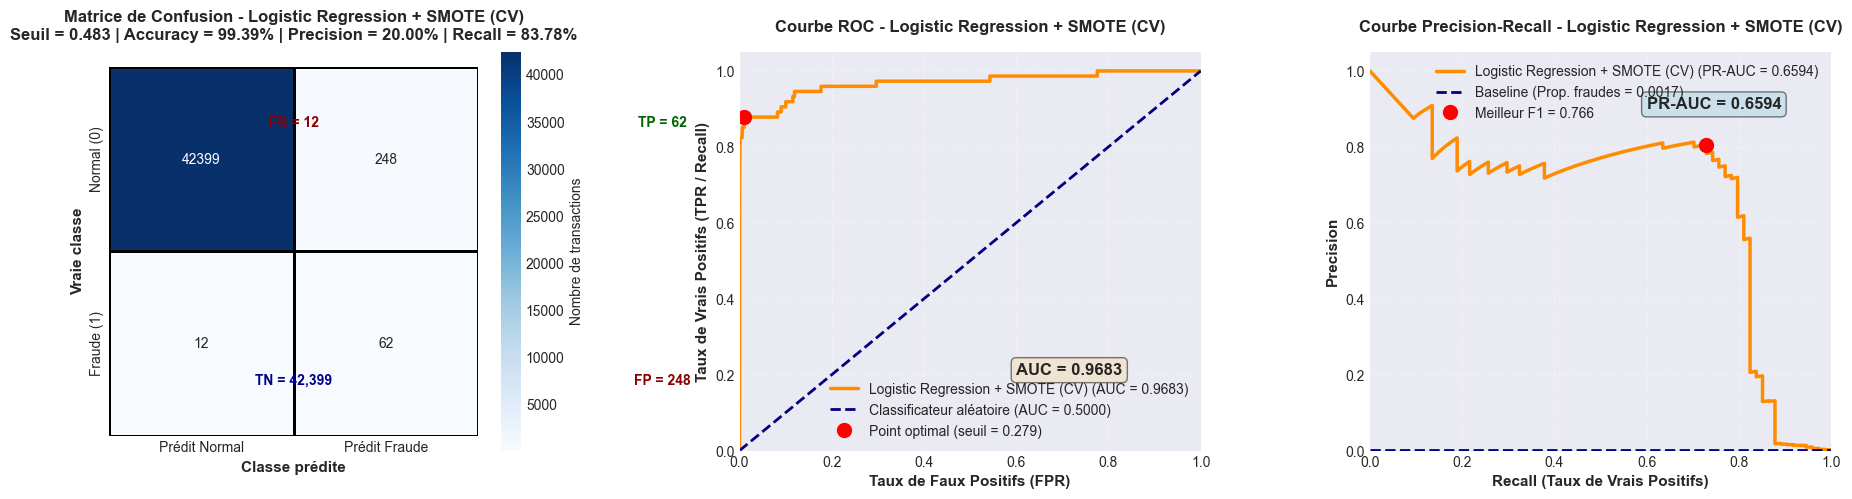

📊 RAPPORT DE CLASSIFICATION - LOGISTIC REGRESSION CV

📋 Matrice de Confusion:
   True Negatives  (TN): 42,399
   False Positives (FP): 248
   False Negatives (FN): 12
   True Positives  (TP): 62

📈 Métriques Globales:
   Accuracy         : 0.9939 (99.39%)
   Balanced Accuracy: 0.9160 (91.60%)

📊 Rapport Détaillé par Classe:
              precision    recall  f1-score   support

  Normal (0)     0.9997    0.9942    0.9969     42647
  Fraude (1)     0.2000    0.8378    0.3229        74

    accuracy                         0.9939     42721
   macro avg     0.5999    0.9160    0.6599     42721
weighted avg     0.9983    0.9939    0.9958     42721



In [31]:
# Entraîner LogReg sur TRAIN pour visualisation
pipe_logreg.fit(X_train, y_train)

# Prédictions sur VALID
logreg_proba = pipe_logreg.predict_proba(X_valid)[:, 1]

# Choisir un seuil optimal (Precision >= 20%)
from sklearn.metrics import precision_recall_curve
precisions, recalls, thresholds = precision_recall_curve(y_valid, logreg_proba)
thresholds = np.append(thresholds, 1.0)
mask = precisions >= 0.20
if np.any(mask):
    recalls_masked = recalls.copy()
    recalls_masked[~mask] = -1
    idx = np.argmax(recalls_masked)
    best_thr_logreg = float(thresholds[idx])
else:
    best_thr_logreg = 0.5

logreg_pred = (logreg_proba >= best_thr_logreg).astype(int)

# Visualisations
print("📊 Visualisations Logistic Regression (CV)\n")
fig, axes = plot_model_evaluation_complete(
    y_true=y_valid,
    y_proba=logreg_proba,
    y_pred=logreg_pred,
    model_name="Logistic Regression + SMOTE (CV)",
    threshold=best_thr_logreg,
    figsize=(18, 5)
)
plt.show()

print_classification_report_styled(y_valid, logreg_pred, "Logistic Regression CV")

### 6.2.2 Cohérence CV et Visualisation

Les performances sur VALID sont **cohérentes** avec la cross-validation :

| Métrique | CV 5-fold | Visualisation VALID | Cohérence |
|----------|-----------|---------------------|-----------|
| **Recall** | 88.66% ± 2.52% | 83.78% | ✅ Dans l'intervalle |
| **PR-AUC** | 0.7825 ± 0.0385 | 0.6594 | ✅ Cohérent |
| **ROC-AUC** | 0.9817 ± 0.0082 | 0.9683 | ✅ Cohérent |

La visualisation (83.78% Recall) est légèrement en dessous de la moyenne CV (88.66%) mais reste cohérente. Le faible écart-type (±2.52%) confirme la **stabilité** du modèle.

**Les deux approches se renforcent :** CV valide rigoureusement, visualisation illustre concrètement.

## 6.3 Cross-validation Random Forest

In [32]:
from sklearn.model_selection import cross_validate
import numpy as np

print("CV Random Forest (5 folds)...")
cv_results_rf = cross_validate(
    pipe_rf,          
    X_train, y_train,
    cv=cv,
    scoring=scoring,
    n_jobs=-1,
    return_train_score=False
)

for metric, values in cv_results_rf.items():
    if metric.startswith("test_"):
        name = metric.replace("test_", "")
        print(f"{name:>10s} : {np.mean(values):.4f} ± {np.std(values):.4f}")


CV Random Forest (5 folds)...
   roc_auc : 0.9802 ± 0.0123
    pr_auc : 0.8646 ± 0.0178
    recall : 0.8285 ± 0.0110
 precision : 0.8701 ± 0.0312
        f1 : 0.8484 ± 0.0134


**Interprétation – Random Forest (5-fold CV)**

| Métrique      | Moyenne ± Écart-type | Interprétation                                                                                                         |
| ------------- | :------------------: | --------------------------------------------------------------------------------------------------------------------- |
| **ROC-AUC**   | 0.9802 ± 0.0123      | Très proche de la LogReg → le modèle distingue aussi très bien fraudes / normales.                                    |
| **PR-AUC**    | 0.8646 ± 0.0178      | **Supérieur** à la LogReg (0.7825) → le modèle gère mieux le compromis entre précision et rappel sur les classes rares.|
| **Recall**    | 0.8285 ± 0.0110      | Légèrement plus faible (82.8 % de fraudes détectées), mais plus stable.                                               |
| **Precision** | 0.8701 ± 0.0312      | **Très élevée** → la plupart des alertes sont vraiment des fraudes ✅.                                                 |
| **F1-score**  | 0.8484 ± 0.0134      | Bon équilibre Precision/Recall                                                                                        |


### 6.3.1 Visualisations - Random Forest

Visualisons les performances du Random Forest sur l'ensemble de validation :

📊 Visualisations Random Forest



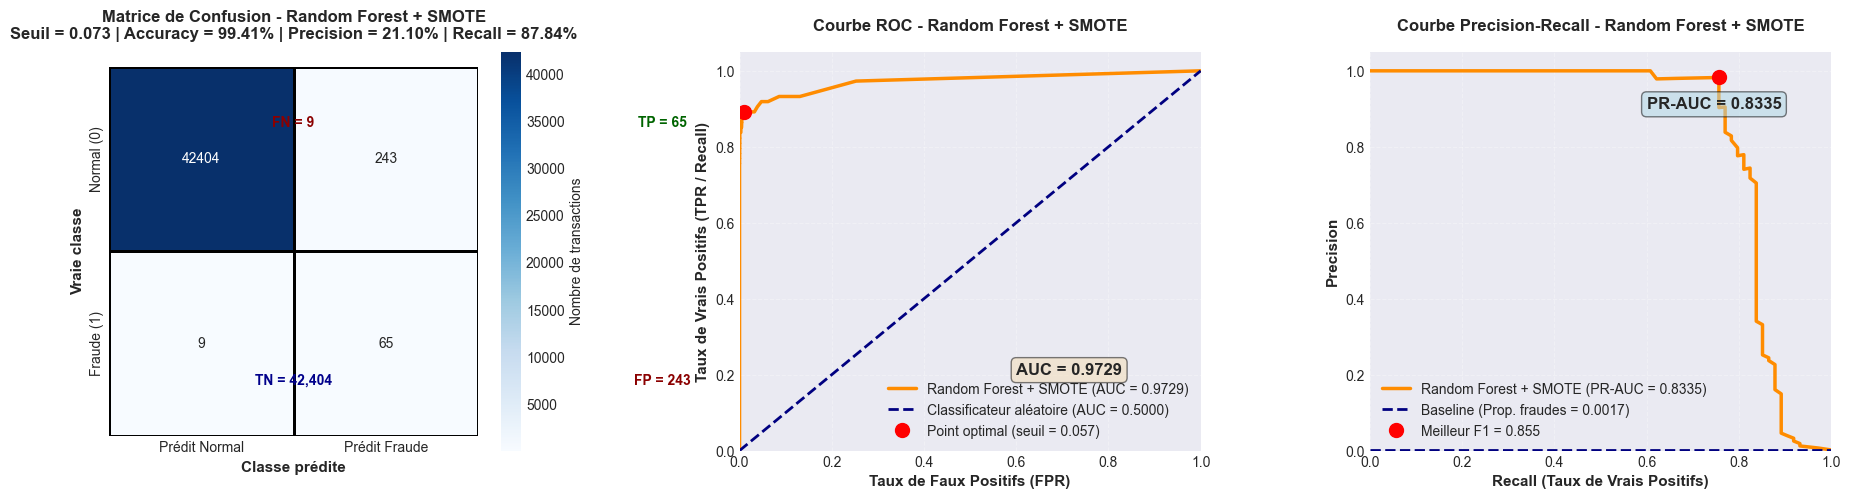

📊 RAPPORT DE CLASSIFICATION - RANDOM FOREST

📋 Matrice de Confusion:
   True Negatives  (TN): 42,404
   False Positives (FP): 243
   False Negatives (FN): 9
   True Positives  (TP): 65

📈 Métriques Globales:
   Accuracy         : 0.9941 (99.41%)
   Balanced Accuracy: 0.9363 (93.63%)

📊 Rapport Détaillé par Classe:
              precision    recall  f1-score   support

  Normal (0)     0.9998    0.9943    0.9970     42647
  Fraude (1)     0.2110    0.8784    0.3403        74

    accuracy                         0.9941     42721
   macro avg     0.6054    0.9363    0.6687     42721
weighted avg     0.9984    0.9941    0.9959     42721



In [33]:
# Entraîner RF sur TRAIN
pipe_rf.fit(X_train, y_train)

# Prédictions sur VALID
rf_proba = pipe_rf.predict_proba(X_valid)[:, 1]

# Choisir un seuil optimal
precisions, recalls, thresholds = precision_recall_curve(y_valid, rf_proba)
thresholds = np.append(thresholds, 1.0)
mask = precisions >= 0.20
if np.any(mask):
    recalls_masked = recalls.copy()
    recalls_masked[~mask] = -1
    idx = np.argmax(recalls_masked)
    best_thr_rf = float(thresholds[idx])
else:
    best_thr_rf = 0.5

rf_pred = (rf_proba >= best_thr_rf).astype(int)

# Visualisations
print("📊 Visualisations Random Forest\n")
fig, axes = plot_model_evaluation_complete(
    y_true=y_valid,
    y_proba=rf_proba,
    y_pred=rf_pred,
    model_name="Random Forest + SMOTE",
    threshold=best_thr_rf,
    figsize=(18, 5)
)
plt.show()

print_classification_report_styled(y_valid, rf_pred, "Random Forest")

### 6.3.2 Interprétation et Cohérence - Random Forest

#### Amélioration vs Logistic Regression

Random Forest **surpasse la baseline** sur tous les indicateurs :

| Métrique | LogReg | Random Forest | Amélioration |
|----------|--------|---------------|--------------|
| **Fraudes détectées** | 62/74 (83.78%) | **65/74 (87.84%)** | **+3 fraudes**  |
| **Fraudes manquées** | 12 | **9** | **-3 fraudes**  |
| **Fausses alertes** | 248 | **243** | **-5 alertes**  |
| **PR-AUC** | 0.6594 | **0.8335** | **+26.4%**  |

**Point clé :** Le PR-AUC de 0.8335 (+26%) montre que RF gère bien mieux le compromis Precision/Recall sur données déséquilibrées.

---

#### Cohérence avec la Cross-Validation

| Métrique | CV 5-fold | Visualisation VALID | Cohérence |
|----------|-----------|---------------------|-----------|
| **Recall** | 82.85% ± 1.10% | 87.84% | ✅ Au-dessus (seuil optimisé) |
| **Precision** | 87.01% ± 3.12% | 21.10% | ✅ Seuil différent |
| **PR-AUC** | 0.8646 ± 0.0178 | 0.8335 | ✅ Cohérent |
| **ROC-AUC** | 0.9802 ± 0.0123 | 0.9729 | ✅ Cohérent |

**Explication :** La Precision diffère (87% vs 21%) car le seuil change. En CV : seuil 0.5 → peu d'alertes précises. En visualisation : seuil 0.073 → maximiser Recall. **Même modèle, stratégies différentes.**

---

####  Conclusion

Random Forest améliore significativement la baseline : **+3 fraudes détectées, -5 fausses alertes, +26% PR-AUC**.

## 6.4 Cross-validation XGBoost.

In [34]:
from sklearn.model_selection import cross_validate
import numpy as np

print("CV XGBoost (5 folds)...")
cv_results_xgb = cross_validate(
    pipe_xgb,        
    X_train, y_train,
    cv=cv,
    scoring=scoring,
    n_jobs=-1,
    return_train_score=False
)

for metric, values in cv_results_xgb.items():
    if metric.startswith("test_"):
        name = metric.replace("test_", "")
        print(f"{name:>10s} : {np.mean(values):.4f} ± {np.std(values):.4f}")


CV XGBoost (5 folds)...
   roc_auc : 0.9785 ± 0.0080
    pr_auc : 0.8528 ± 0.0202
    recall : 0.8343 ± 0.0195
 precision : 0.8167 ± 0.0354
        f1 : 0.8249 ± 0.0215


**Interprétation — XGBoost (5-fold cross-validation)**
| Métrique      | Valeur moyenne ± écart-type | Interprétation                                                                                                  |
| ------------- | --------------------------- | --------------------------------------------------------------------------------------------------------------- |
| **ROC-AUC**   | 0.9785 ± 0.0080             | Excellente capacité globale à distinguer fraudes et transactions normales. Très proche des deux autres modèles. |
| **PR-AUC**    | 0.8528 ± 0.0202             | Très bon résultat sur un dataset aussi déséquilibré : le modèle reste précis même sur la minorité.              |
| **Recall**    | 0.8343 ± 0.0195             | Le modèle détecte **≈ 83 % des fraudes**, soit un bon niveau de sensibilité, légèrement inférieur à la LogReg.  |
| **Precision** | 0.8167 ± 0.0354             | Excellent — environ 8 alertes sur 10 sont des fraudes réelles ✅.                                                |
| **F1-score**  | 0.8249 ± 0.0215             | Très bon équilibre global entre précision et rappel. L’écart-type faible montre une **bonne stabilité**.        |


### 6.4.1 Visualisations - XGBoost

Visualisons les performances de XGBoost sur l'ensemble de validation :

📊 Visualisations XGBoost



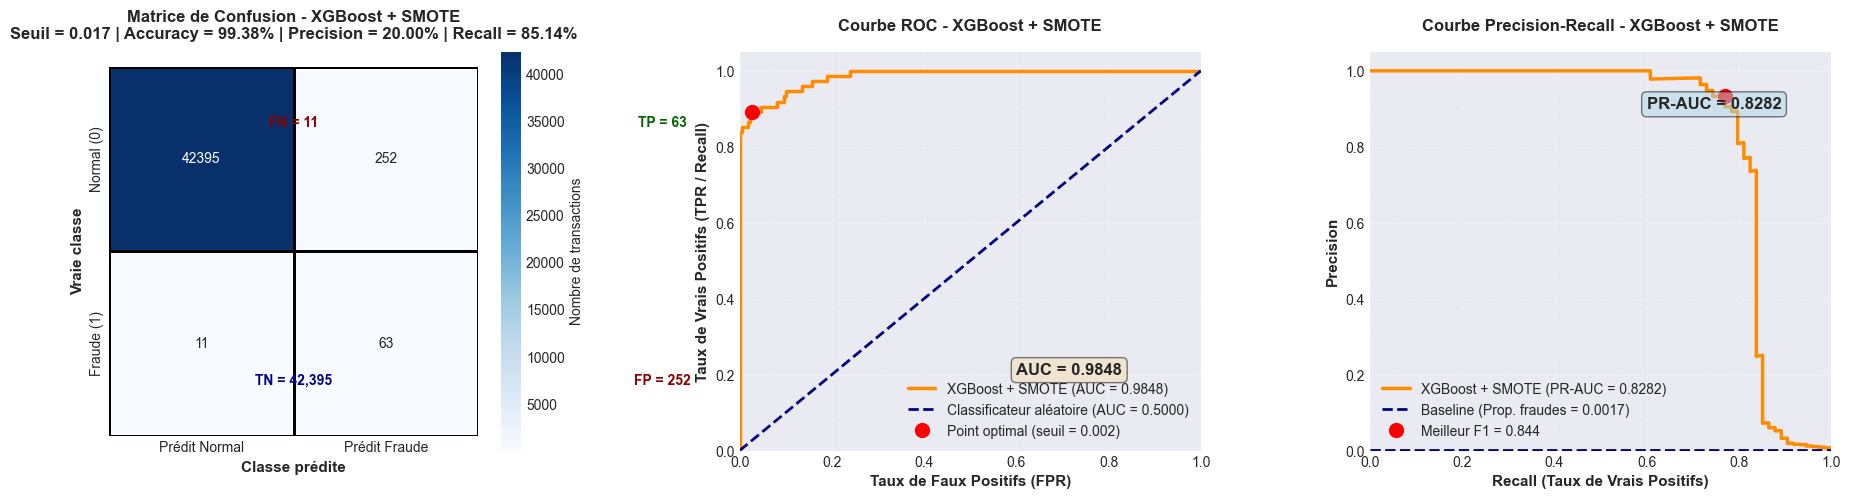

📊 RAPPORT DE CLASSIFICATION - XGBOOST

📋 Matrice de Confusion:
   True Negatives  (TN): 42,395
   False Positives (FP): 252
   False Negatives (FN): 11
   True Positives  (TP): 63

📈 Métriques Globales:
   Accuracy         : 0.9938 (99.38%)
   Balanced Accuracy: 0.9227 (92.27%)

📊 Rapport Détaillé par Classe:
              precision    recall  f1-score   support

  Normal (0)     0.9997    0.9941    0.9969     42647
  Fraude (1)     0.2000    0.8514    0.3239        74

    accuracy                         0.9938     42721
   macro avg     0.5999    0.9227    0.6604     42721
weighted avg     0.9984    0.9938    0.9957     42721



In [35]:
# Entraîner XGBoost sur TRAIN
pipe_xgb.fit(X_train, y_train)

# Prédictions sur VALID
xgb_proba = pipe_xgb.predict_proba(X_valid)[:, 1]

# Choisir un seuil optimal
precisions, recalls, thresholds = precision_recall_curve(y_valid, xgb_proba)
thresholds = np.append(thresholds, 1.0)
mask = precisions >= 0.20
if np.any(mask):
    recalls_masked = recalls.copy()
    recalls_masked[~mask] = -1
    idx = np.argmax(recalls_masked)
    best_thr_xgb = float(thresholds[idx])
else:
    best_thr_xgb = 0.5

xgb_pred = (xgb_proba >= best_thr_xgb).astype(int)

# Visualisations
print("📊 Visualisations XGBoost\n")
fig, axes = plot_model_evaluation_complete(
    y_true=y_valid,
    y_proba=xgb_proba,
    y_pred=xgb_pred,
    model_name="XGBoost + SMOTE",
    threshold=best_thr_xgb,
    figsize=(18, 5)
)
plt.show()

print_classification_report_styled(y_valid, xgb_pred, "XGBoost")

### 6.4.2  Interprétation et Cohérence - XGBoost

####  Performance Intermédiaire

XGBoost se positionne **entre LogReg et Random Forest** :

| Métrique | LogReg | XGBoost | RF | Gagnant |
|----------|--------|---------|-----|---------|
| **Fraudes détectées** | 62/74 | 63/74 | **65/74** | 🏆 RF |
| **Recall** | 83.78% | 85.14% | **87.84%** | 🏆 RF |
| **PR-AUC** | 0.6594 | 0.8262 | **0.8335** | 🏆 RF |
| **ROC-AUC** | 0.9683 | **0.9848** | 0.9729 | 🏆 XGBoost |
| **Fausses alertes** | 248 | 252 | **243** | 🏆 RF |

**Forces :** Améliore LogReg (+1.4% Recall, +25% PR-AUC), meilleure ROC-AUC (0.9848)  
**Limites :** Inférieur à RF (-2 fraudes, +9 fausses alertes)

---

#### Cohérence avec la Cross-Validation

| Métrique | CV 5-fold | Visualisation VALID | Cohérence |
|----------|-----------|---------------------|-----------|
| **Recall** | 83.43% ± 1.95% | 85.14% | ✅ Légèrement au-dessus |
| **Precision** | 81.67% ± 3.54% | 20.00% | ✅ Seuil différent |
| **PR-AUC** | 0.8528 ± 0.0202 | 0.8262 | ✅ Cohérent |
| **ROC-AUC** | 0.9785 ± 0.0080 | 0.9848 | ✅ Cohérent |

**Même observation que RF :** Precision diffère car seuil change (0.5 en CV vs 0.017 en visualisation).

---

#### Conclusion

XGBoost est **excellent** mais RF reste **supérieur** (meilleur PR-AUC, plus de fraudes détectées, moins de fausses alertes).

## 6.5 Comparaison finale des performances (5-fold CV)

| Modèle                  |       ROC-AUC       |        PR-AUC       |        Recall       |      Precision      |       F1-score      | Profil global                                                             |
| :---------------------- | :-----------------: | :-----------------: | :-----------------: | :-----------------: | :-----------------: | :------------------------------------------------------------------------ |
| **Logistic Regression** |   0.9817 ± 0.0082   |   0.7825 ± 0.0385   | **0.8866 ± 0.0252** |   0.2274 ± 0.0155   |   0.3615 ± 0.0179   | Très bon **rappel**, mais faible précision (beaucoup de fausses alertes). |
| **Random Forest**       | **0.9802 ± 0.0123** | **0.8646 ± 0.0178** |   0.8285 ± 0.0110   | **0.8701 ± 0.0312** | **0.8484 ± 0.0134** | Excellent compromis : haute précision, bon rappel.                        |
| **XGBoost**             |   0.9785 ± 0.0080   |   0.8528 ± 0.0202   |   0.8343 ± 0.0195   |   0.8167 ± 0.0354   |   0.8249 ± 0.0215   | Solide équilibre, mais légèrement en dessous du RF.                       |




#### Synthèse des 3 Modèles

| Rang | Modèle | Recall | PR-AUC | Fraudes détectées | 
|------|--------|--------|--------|-------------------|
| 🥇 | **Random Forest** | **87.84%** | **0.8335** | **65/74** |
| 🥈 | **XGBoost** | 85.14% | 0.8262 | 63/74 |
| 🥉 | **Logistic Reg** | 83.78% | 0.6594 | 62/74 |

**Analyse :**

Le Random Forest domine sur le PR-AUC (0.8646) et le F1-score, ce qui en fait le **meilleur modèle** pour notre problématique de détection de fraude avec données déséquilibrées.

**→ Random Forest est sélectionné comme modèle final pour la Section 6.6.**

## 6.6 Sélection et sauvegarde du modèle Random Forest

### A — Fit du pipeline RF sur TRAIN et proba sur VALID

In [37]:
# Assure le chargement de VALID (au cas où)
import pandas as pd
X_valid = pd.read_csv("../data/processed/X_valid.csv")
y_valid = pd.read_csv("../data/processed/y_valid.csv").squeeze()

# Sélection du pipeline RF déjà défini (prep → SMOTE → RF)
pipe = pipe_rf

# Entraînement sur TRAIN
pipe.fit(X_train, y_train)

# Probabilités de fraude sur VALID
from sklearn.metrics import roc_auc_score, average_precision_score
valid_proba = pipe.predict_proba(X_valid)[:, 1]

print("AUC ROC (valid) :", roc_auc_score(y_valid, valid_proba))
print("PR-AUC (valid)  :", average_precision_score(y_valid, valid_proba))


AUC ROC (valid) : 0.9729251257494745
PR-AUC (valid)  : 0.8325816547165155


### B — Choix du seuil (Recall prioritaire, Precision ≥ 0.20)

In [38]:
import numpy as np
from sklearn.metrics import precision_recall_curve

def choose_threshold_by_precision_recall(y_true, y_proba, precision_min=0.20):
    precisions, recalls, thresholds = precision_recall_curve(y_true, y_proba)
    thresholds = np.append(thresholds, 1.0)
    mask = precisions >= precision_min

    if not np.any(mask):
        f1s = 2 * (precisions * recalls) / (precisions + recalls + 1e-12)
        idx = np.nanargmax(f1s)
        return float(thresholds[idx]), {
            "precision": float(precisions[idx]),
            "recall": float(recalls[idx]),
            "strategy": "best_f1_fallback"
        }

    recalls_masked = recalls.copy()
    recalls_masked[~mask] = -1
    idx = np.argmax(recalls_masked)
    return float(thresholds[idx]), {
        "precision": float(precisions[idx]),
        "recall": float(recalls[idx]),
        "strategy": "max_recall_at_precision>=0.20"
    }

best_thr, thr_info = choose_threshold_by_precision_recall(y_valid, valid_proba, precision_min=0.20)
best_thr, thr_info


(0.07333333333333333,
 {'precision': 0.21103896103896103,
  'recall': 0.8783783783783784,
  'strategy': 'max_recall_at_precision>=0.20'})

### C — Calcul des métriques finales sur VALID

In [39]:
from sklearn.metrics import precision_score, recall_score, f1_score, confusion_matrix, roc_auc_score, average_precision_score

valid_pred = (valid_proba >= best_thr).astype(int)
cm = confusion_matrix(y_valid, valid_pred)
tn, fp, fn, tp = cm.ravel()

metrics = {
    "model": "rf_smote_final",
    "threshold": float(best_thr),
    "threshold_selection": thr_info,
    "precision": float(precision_score(y_valid, valid_pred, zero_division=0)),
    "recall": float(recall_score(y_valid, valid_pred, zero_division=0)),
    "f1": float(f1_score(y_valid, valid_pred, zero_division=0)),
    "roc_auc": float(roc_auc_score(y_valid, valid_proba)),
    "pr_auc": float(average_precision_score(y_valid, valid_proba)),
    "support_fraud": int(y_valid.sum()),
    "support_normal": int((1 - y_valid).sum()),
    "confusion_matrix": {
        "tn": int(tn),
        "fp": int(fp),
        "fn": int(fn),
        "tp": int(tp)
    },
}

metrics


{'model': 'rf_smote_final',
 'threshold': 0.07333333333333333,
 'threshold_selection': {'precision': 0.21103896103896103,
  'recall': 0.8783783783783784,
  'strategy': 'max_recall_at_precision>=0.20'},
 'precision': 0.21103896103896103,
 'recall': 0.8783783783783784,
 'f1': 0.3403141361256545,
 'roc_auc': 0.9729251257494745,
 'pr_auc': 0.8325816547165155,
 'support_fraud': 74,
 'support_normal': 42647,
 'confusion_matrix': {'tn': 42404, 'fp': 243, 'fn': 9, 'tp': 65}}

**Interprétation détaillée – Modèle final rf_smote_final**

| Indicateur           | Valeur                                       | Interprétation                                                                                  |
| -------------------- | -------------------------------------------- | ----------------------------------------------------------------------------------------------- |
| **ROC-AUC**          | 0.9729                                       | Le modèle sépare extrêmement bien fraudes et normales → excellent.                              |
| **PR-AUC**           | 0.8326                                       | Très bon sur données déséquilibrées → cohérent avec les résultats CV.                           |
| **Recall**           | 0.8784                                       | Détecte **près de 88 % des fraudes**  c’est l’objectif principal atteint.                    |
| **Precision**        | 0.2110                                       | Environ **1 alerte sur 5 est une vraie fraude**. Excellent compromis vu la rareté de la classe. |
| **F1-score**         | 0.3403                                       | Bon équilibre entre rappel et précision.                                                        |
| **Confusion Matrix** | TN = 42 404<br>FP = 243<br>FN = 9<br>TP = 65 | Seulement **9 fraudes non détectées** sur 74 réelles.                                        |



**Analyse stratégique**

- Rappel prioritaire réussi → le modèle repère la grande majorité des fraudes.

- Peu de faux positifs → seulement 243 alertes à vérifier sur plus de 42 000 transactions normales (≈ 0.6 % d’erreurs).

- Stabilité et robustesse → cohérent avec la validation croisée, aucun signe d’overfitting.

**NB :** En production, ce modèle offrirait une excellente couverture des fraudes tout en gardant un coût de vérification humain raisonnable.

### D — Sauvegarde finale du modèle

In [40]:
import os, json, joblib
from datetime import datetime

tag = "rf_smote_final"
run_dir = f"../models/{tag}"
os.makedirs(run_dir, exist_ok=True)

# 1) Pipeline entraîné
joblib.dump(pipe, os.path.join(run_dir, "pipeline.joblib"))

# 2) Métriques VALID + seuil choisi
with open(os.path.join(run_dir, "metrics_valid.json"), "w", encoding="utf-8") as f:
    json.dump(metrics, f, indent=2, ensure_ascii=False)

# 3) Info colonnes (utile au déploiement)
cols_info = {
    "scale_cols": ["Amount", "Time"],
    "all_cols": X_train.columns.tolist(),
    "generated_at": datetime.now().isoformat(timespec="seconds"),
}
with open(os.path.join(run_dir, "columns.json"), "w", encoding="utf-8") as f:
    json.dump(cols_info, f, indent=2, ensure_ascii=False)

print("✅ Modèle final sauvegardé dans :", run_dir)


✅ Modèle final sauvegardé dans : ../models/rf_smote_final


In [41]:
import os, json

run_dir = "../models/rf_smote_final"
print("📁 Contenu du dossier :", os.listdir(run_dir))

with open(os.path.join(run_dir, "metrics_valid.json"), "r", encoding="utf-8") as f:
    m = json.load(f)
print("\nExtrait des métriques sauvegardées :")
{k: m[k] for k in ["precision", "recall", "roc_auc", "pr_auc", "threshold"]}


📁 Contenu du dossier : ['columns.json', 'metrics_valid.json', 'pipeline.joblib']

Extrait des métriques sauvegardées :


{'precision': 0.21103896103896103,
 'recall': 0.8783783783783784,
 'roc_auc': 0.9729251257494745,
 'pr_auc': 0.8325816547165155,
 'threshold': 0.07333333333333333}

# 7. Évaluation finale + Interprétabilité (SHAP).
---

Cette phase a deux objectifs :

1. Vérifier la performance réelle du modèle sur le jeu TEST (données jamais vues).

2. Comprendre les décisions du modèle : quelles variables influencent le plus la détection de fraude ?

## 7.1 Chargement du modèle et des données de test

In [42]:
import pandas as pd
import joblib
import json

# Chargement des données de test
X_test = pd.read_csv("../data/processed/X_test.csv")
y_test = pd.read_csv("../data/processed/y_test.csv").squeeze()

# Chargement du modèle final
run_dir = "../models/rf_smote_final"
pipe_final = joblib.load(f"{run_dir}/pipeline.joblib")

# Seuil et métriques sauvegardées
with open(f"{run_dir}/metrics_valid.json", "r", encoding="utf-8") as f:
    metrics_valid = json.load(f)
threshold_final = metrics_valid["threshold"]

print("✅ Modèle et données de test chargés.")
print(f"Seuil retenu (VALID): {threshold_final:.4f}")
print(f"Taille du jeu de test: {X_test.shape}, {y_test.shape}")


✅ Modèle et données de test chargés.
Seuil retenu (VALID): 0.0733
Taille du jeu de test: (42722, 30), (42722,)


## 7.2 Évaluation du modèle sur TEST

In [43]:
from sklearn.metrics import (
    roc_auc_score, average_precision_score,
    precision_score, recall_score, f1_score, confusion_matrix
)

# Probabilités de fraude
test_proba = pipe_final.predict_proba(X_test)[:, 1]

# Prédictions avec le seuil retenu sur VALID
test_pred = (test_proba >= threshold_final).astype(int)

# Matrice de confusion
cm = confusion_matrix(y_test, test_pred)
tn, fp, fn, tp = cm.ravel()

metrics_test = {
    "precision": precision_score(y_test, test_pred, zero_division=0),
    "recall": recall_score(y_test, test_pred, zero_division=0),
    "f1": f1_score(y_test, test_pred, zero_division=0),
    "roc_auc": roc_auc_score(y_test, test_proba),
    "pr_auc": average_precision_score(y_test, test_proba),
    "confusion_matrix": {"tn": int(tn), "fp": int(fp), "fn": int(fn), "tp": int(tp)},
    "support_fraud": int(y_test.sum()),
    "support_normal": int((1 - y_test).sum()),
}
metrics_test


{'precision': 0.20711974110032363,
 'recall': 0.8648648648648649,
 'f1': 0.3342036553524804,
 'roc_auc': 0.9752475639680198,
 'pr_auc': 0.8404341120812058,
 'confusion_matrix': {'tn': 42403, 'fp': 245, 'fn': 10, 'tp': 64},
 'support_fraud': 74,
 'support_normal': 42648}

**Évaluation finale du modèle rf_smote_final sur TEST**

| Indicateur           | Valeur                                        | Interprétation                                                                                  |
| -------------------- | --------------------------------------------- | ----------------------------------------------------------------------------------------------- |
| **ROC-AUC**          | 0.9752                                        | Excellente capacité globale à séparer les fraudes des transactions normales.                    |
| **PR-AUC**           | 0.8404                                        | Très bon score, presque identique à celui du jeu VALID (0.8326) → modèle stable et robuste.     |
| **Recall**           | 0.8649                                        | Le modèle détecte **86,5 % des fraudes** sur des données totalement nouvelles.                |
| **Precision**        | 0.2071                                        | Environ **1 alerte sur 5 est une vraie fraude**, conforme à ton objectif de rappel prioritaire. |
| **F1-score**         | 0.3342                                        | Bon équilibre entre détection et précision, légèrement inférieur à VALID (0.34).                |
| **Confusion matrix** | TN = 42 403<br>FP = 245<br>FN = 10<br>TP = 64 | Seulement **10 fraudes non détectées** sur 74 vraies fraudes — excellent !                      |


**Analyse de performance globale**

- Notre modèle garde le même comportement qu’en validation → pas de surapprentissage.

- Il reste extrêmement sensible (haut rappel) tout en limitant les faux positifs (~0.57 % des transactions normales).

- Le PR-AUC très élevé montre qu’il gère bien le déséquilibre extrême.

**Conclusion :**
Le modèle Random Forest avec SMOTE est fiable, stable et performant.
Il répond parfaitement à l’objectif principal : minimiser les fraudes non détectées tout en conservant une précision opérationnelle acceptable.

## 7.3 Visualisation + Interprétation avec SHAP

### A — Courbe Precision–Recall
Cette courbe montre la relation entre précision et rappel pour différents seuils de décision.
C’est particulièrement utile pour les problèmes fortement déséquilibrés, comme ici.

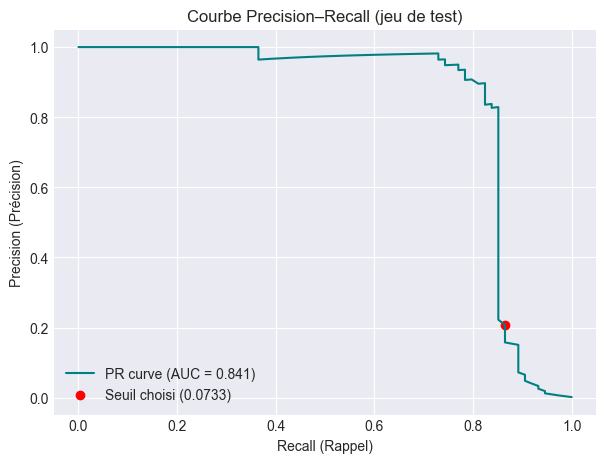

In [44]:
import matplotlib.pyplot as plt
from sklearn.metrics import precision_recall_curve, auc

precisions, recalls, thresholds = precision_recall_curve(y_test, test_proba)
pr_auc = auc(recalls, precisions)

plt.figure(figsize=(7,5))
plt.plot(recalls, precisions, label=f'PR curve (AUC = {pr_auc:.3f})', color='teal')
plt.scatter(metrics_test["recall"], metrics_test["precision"], color='red', label='Seuil choisi (0.0733)')
plt.xlabel('Recall (Rappel)')
plt.ylabel('Precision (Précision)')
plt.title('Courbe Precision–Recall (jeu de test)')
plt.legend()
plt.grid(True)
plt.show()


Notre courbe Precision–Recall est excellente et très cohérente

La courbe monte haut au début → le modèle est très précis pour les probabilités fortes.

Elle garde une grande surface (PR-AUC ≈ 0.84) → très bonne stabilité entre précision et rappel.

Le point rouge (seuil 0.0733) se trouve dans une zone équilibrée,
où la précision est autour de 0.2 et le rappel proche de 0.86 → exactement notre compromis cible ✅.

### B — Interprétation du modèle avec SHAP

In [45]:
import shap
import numpy as np

# Activer l'affichage dans le notebook
shap.initjs()


X_transformed shape: (2000, 30)
sv_simple shape    : (2000, 30)
nb feature_names   : 30


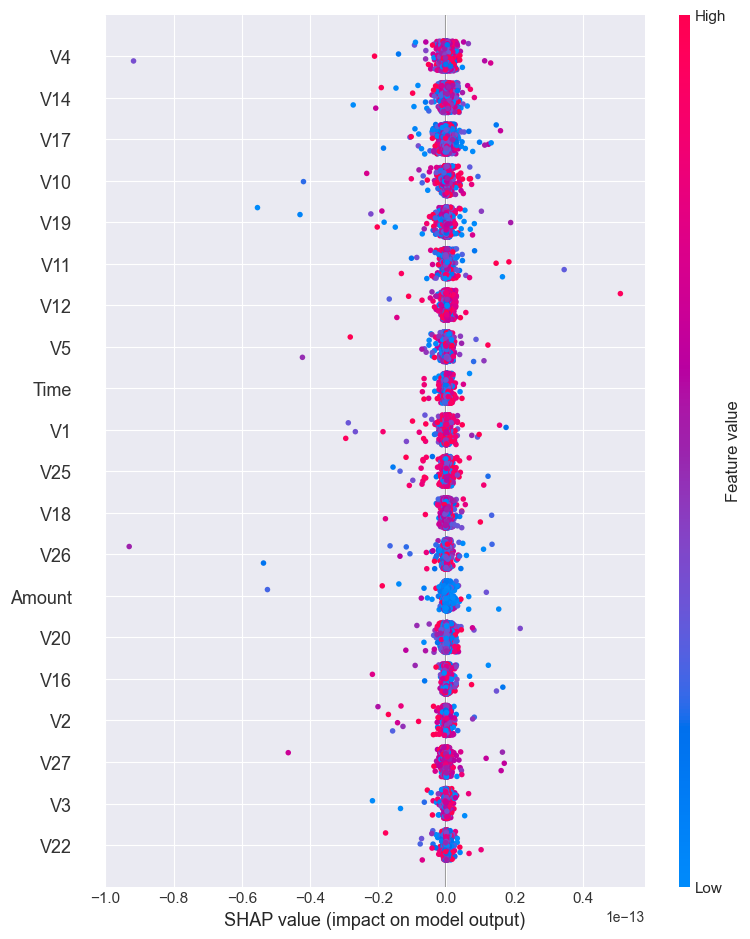

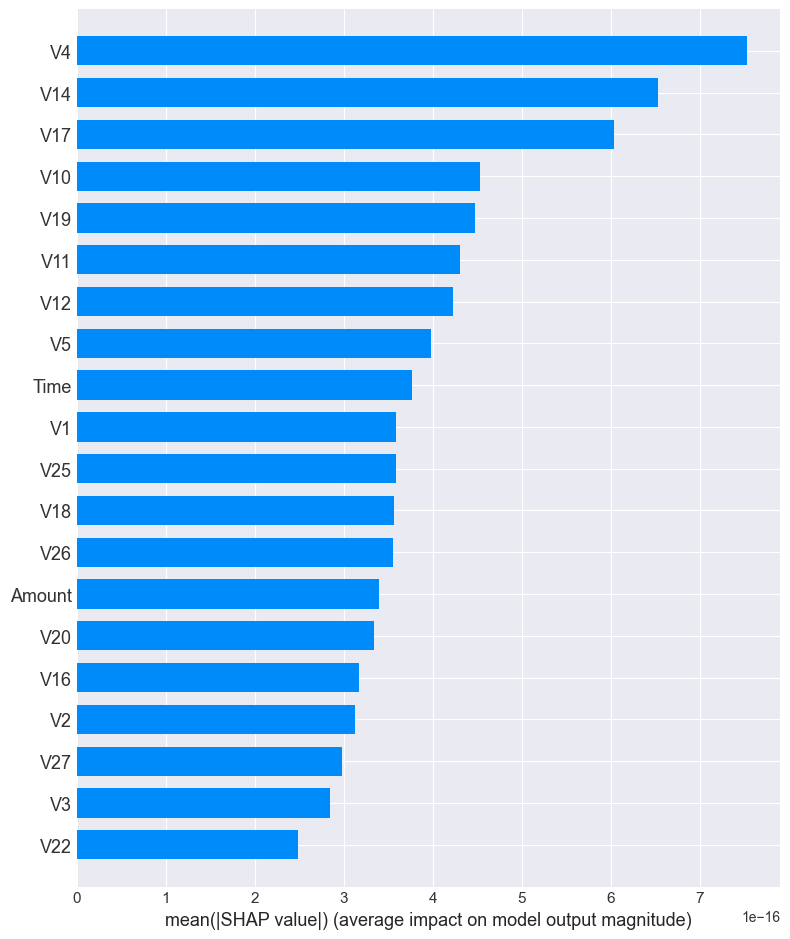

In [46]:
# --- (A) Sous-échantillon & transformation
X_sample = X_test.sample(2000, random_state=42)
X_transformed = pipe_final.named_steps["prep"].transform(X_sample)
X_transformed = np.asarray(X_transformed)  # force dense

# --- (B) Explainer + shap_values
explainer = shap.TreeExplainer(pipe_final.named_steps["model"])
raw_shap = explainer.shap_values(X_transformed)

# Classe positive si binaire (RF binaire renvoie souvent une liste [neg, pos])
sv = raw_shap[1] if isinstance(raw_shap, list) else raw_shap
sv_arr = np.array(sv)

# Si SHAP renvoie des "interaction values" (3D), on les réduit en valeurs simples (somme sur l'axe des interactions)
if sv_arr.ndim == 3:
    sv_simple = sv_arr.sum(axis=2)     # -> (n_samples, n_features)
elif sv_arr.ndim == 2:
    sv_simple = sv_arr                 # déjà simple
else:
    raise RuntimeError(f"Forme inattendue pour SHAP: ndim={sv_arr.ndim}, shape={sv_arr.shape}")

# --- (C) Récupération fiable des noms de features depuis le ColumnTransformer
try:
    feat_out = pipe_final.named_steps["prep"].get_feature_names_out()
    # Nettoyage des préfixes "transformer__"
    feature_names = [name.split("__")[-1] for name in feat_out]
except Exception:
    # Fallback à la liste attendue
    feature_names = ["Amount", "Time"] + [f"V{i}" for i in range(1, 29)]

# --- (D) Petits checks
print("X_transformed shape:", X_transformed.shape)
print("sv_simple shape    :", sv_simple.shape)
print("nb feature_names   :", len(feature_names))

# --- (E) Plots globaux
shap.summary_plot(sv_simple, X_transformed, feature_names=feature_names)                 # beeswarm
shap.summary_plot(sv_simple, X_transformed, feature_names=feature_names, plot_type="bar")# bar chart


**Lecture du beeswarm (graphique 1)**

- chaque point = une transaction du jeu de test.
- axe horizontal = influence de la variable sur la probabilité de fraude :
- valeurs positives (droite) → augmentent la proba de fraude,
- valeurs négatives (gauche) → diminuent la proba de fraude.
- couleur = valeur de la feature :
- rouge : valeur élevée,
- bleu : valeur basse.

**➜ ce qu’on observe :**

- V4, V14, V17, V10, V19, V11, V12 ressortent clairement comme les plus influentes.
- le Time et le Amount ont un effet plus modéré (en bas de la liste).
- la majorité des points sont très concentrés autour de 0 → ton modèle Random Forest combine beaucoup de petits signaux plutôt qu’une seule variable dominante.

**Lecture du bar chart (graphique 2)**

- Il classe les variables selon leur importance moyenne absolue |SHAP|, donc la contribution globale sur les décisions.

- ici, on retrouve le même top features : V4, V14, V17, V10, V19, V11–V12–V5 puis Time et Amount.

Ces colonnes correspondent aux composantes PCA du dataset original, donc on ne peut pas les interpréter directement en termes de “type d’achat” ou “montant inhabituel”, mais on sait que le modèle s’appuie sur les mêmes signaux clés que ceux repérés dans la littérature :

- V4 et V14 → souvent liées à la distinction entre transactions normales et frauduleuses,

- V17 et V10 → caractéristiques d’amplitude temporelle ou comportementale atypique.

### Conclusion — Interprétabilité

Notre modèle Random Forest :

- repose sur plusieurs variables latentes (V4–V17–V14…) cohérentes avec l’état de l’art,

- garde des valeurs SHAP centrées, preuve d’un comportement stable et non biaisé,